In [1]:
import numpy as np
from numpy.random import dirichlet as Dir
import hypertools as hyp
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import brainiak.eventseg.event
from timecorr.helpers import z2r, r2z

%matplotlib inline

In [2]:
def DirichletTimeseries(alpha, T, D):
    Y = np.zeros((T, D))
    Y[0, :] = Dir((alpha*np.ones((1, D))).tolist()[0])
    
    for t in np.arange(1, T):
        x = Y[t-1, :] + alpha
        Y[t, :] = Dir(np.divide(x, np.sum(x)))
    return Y

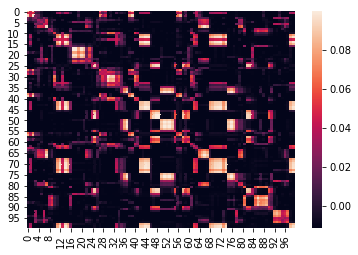

In [3]:
alpha = 0.05
T = 100
D = 10
Y = DirichletTimeseries(alpha, T, D)
sns.heatmap(np.cov(Y))

In [4]:
ev = brainiak.eventseg.event.EventSegment(10)
ev.fit(Y)
bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]

In [6]:
def hmm_wrapper(data, k, plot_it=False, return_model=False):
    ev = brainiak.eventseg.event.EventSegment(k)
    ev.fit(data)
    bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
    
    if plot_it:
        sns.heatmap(np.cov(data))
        ax = plt.gca()
        bounds_aug = np.concatenate(([0],bounds,[data.shape[0]]))
        for i in range(len(bounds_aug)-1):
            rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=1,edgecolor='w',facecolor='none')
            ax.add_patch(rect)
            
    x = np.concatenate(([0],bounds,[data.shape[0]]))
    if not return_model:
        return x
    else:
        return x, ev

In [7]:
def hmm_optimize_k(data, ks):
    def ratio_mean(corrmat, bounds):
        rs = 0.
        for i in np.arange(len(bounds)-1):
            inds = np.arange(bounds[i], bounds[i+1])
            in_event = np.min([np.mean(r2z(corrmat[inds, :][:, inds])), 1.])
            
            out_inds = np.concatenate((np.arange(bounds[i]), np.arange(bounds[i+1], data.shape[0])))
            out_event = np.mean(r2z(corrmat[inds, :][:, out_inds]))
                                                
            rs += np.divide(float(in_event), float(out_event))            
        return rs
    
    vals = np.zeros_like(ks)
    covmat = np.cov(data)
    for i in np.arange(len(ks)):
        next_bounds = hmm_wrapper(data, ks[i])
        vals[i] = ratio_mean(covmat, next_bounds)
    
    plt.plot(ks, vals, 'k')
    plt.xlabel('Number of events')
    plt.ylabel('Covariance ratio sum (in vs. out of event)')
    return ks[np.where(vals == np.max(vals))]

19 discrete events detected.


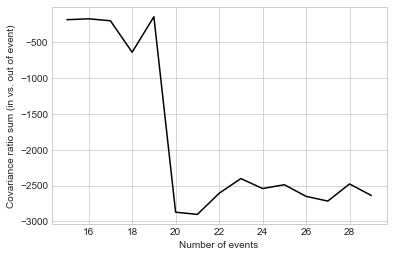

In [33]:
best_k = int(hmm_optimize_k(Y, np.arange(int(np.round(alpha*T*3)), int(np.round(alpha*T*6)))))
print(f'{best_k} discrete events detected.')

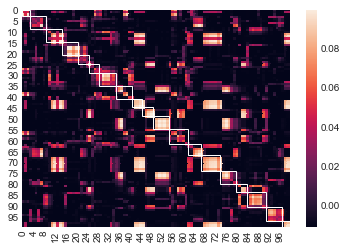

In [34]:
bounds, model = hmm_wrapper(Y, best_k, plot_it=True, return_model=True)

In [108]:
def events_plot(data, event_labels):
    def bounding_box(x, border=0.1):
        minvals = np.min(x, axis=0)
        maxvals = np.max(x, axis=0)
        
        minvals -= np.multiply(border, np.abs(np.min(minvals)))
        maxvals += np.multiply(border, np.abs(np.max(maxvals)))
            
        return plt.plot([minvals[0], minvals[0], maxvals[0], maxvals[0], minvals[0]], [minvals[1], maxvals[1], maxvals[1], minvals[1], minvals[1]], 'k-')
    
    def helper(x, labels, draw_bounding_box=True, size=25, linecolor=[0.5, 0.5, 0.5]):
        colors = sns.color_palette('Spectral', n_colors=len(np.unique(labels)))
        if not (linecolor is None):
            ax = plt.plot(x[:, 0], x[:, 1], '-', color=linecolor, zorder=0)
        ax = plt.scatter(x[:, 0], x[:, 1], s=size, c=np.asarray(colors)[labels, :], zorder=1)
        if draw_bounding_box:
            ax = bounding_box(x)
            plt.axis('off');

    #event_labels = model.predict(data)
    unique_labels = np.unique(event_labels)
    
    coords = hyp.reduce(data, ndims=2, reduce='UMAP')
    
    event_coords = np.zeros([model.n_events, coords.shape[1]])
    for i in np.arange(len(unique_labels)):
        event_coords[i, :] = np.mean(coords[event_labels == unique_labels[i], :], axis=0)
    
    #plt.plot(event_coords[:, 0], event_coords[:, 1], 'k-')
    helper(event_coords, unique_labels, size=50)# size=100, draw_bounding_box=False, linecolor=None)
    #helper(coords, event_labels)
    
    #colors = sns.color_palette('Spectral', n_colors=len(unique_labels))
    #for i in np.arange(len(unique_labels)):
    #    inds = event_labels == unique_labels[i]
    #    plt.plot(event_coords[i, 0], event_coords[i, 1], 'o', c=colors[i], ms=10, mec='k')
        
        #plt.plot(coords[inds, 0], coords[inds, 1], 'o', c=colors[i], mec=None, ms=5)

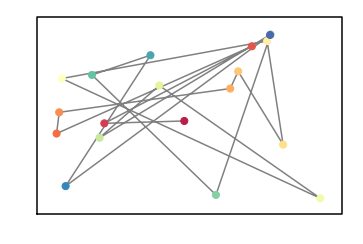

In [109]:
events_plot(Y, model.predict(Y))